In [1]:
import pandas as pd

import os
import math

from datetime import datetime as dt
import time

import numpy as np

from scipy import linalg
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import mixture
import sklearn

from itertools import chain

In [2]:
def encodeTime(df):
    df.time = pd.to_datetime(df.time)

def breakTime(df):
    df['year'] = df.time.dt.year
    df['month'] = df.time.dt.month

def reset():
    weather = pd.read_excel('../05 WeatherData/output_incl_coverage.xlsx')
    encodeTime(weather)
    breakTime(weather)
    return weather

In [3]:
weather = reset()
#weather

In [4]:
#https://stackoverflow.com/questions/6451655/
#python-how-to-convert-datetime-dates-to-decimal-years#6451892

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return fraction*2*math.pi

def toDayFraction(date):
    return (date.hour/24)*2*math.pi

In [5]:
weather['yearFrac'] = weather['time'].apply(toYearFraction)
weather['dayFrac'] = weather['time'].apply(toDayFraction)

weather['year_y'] = np.sin(weather['yearFrac'])
weather['year_x'] = np.cos(weather['yearFrac'])

weather['day_y'] = np.sin(weather['dayFrac'])
weather['day_x'] = np.cos(weather['dayFrac'])

In [6]:
def prune(df,keep = None):
    if keep == None:
        keep = ['SumCh3Ch4','temp','year_y','year_x','day_y','day_x']
    return df.loc[:,keep]

In [7]:
plt.rcParams['figure.figsize'] = [2.0, 2.0]
mpl.style.use('default')

In [8]:
n = 5
model = sklearn.mixture.GaussianMixture(n_components=n, covariance_type='full').fit(
    prune(weather,['SumCh3Ch4','temp',
                   'day_y','day_x'
                  ]))

# newClusters = sklearn.cluster.AgglomerativeClustering(n_clusters = n).fit_predict(prune(weather,['SumCh3Ch4','temp',
#                    'day_y','day_x'
#                   ]))

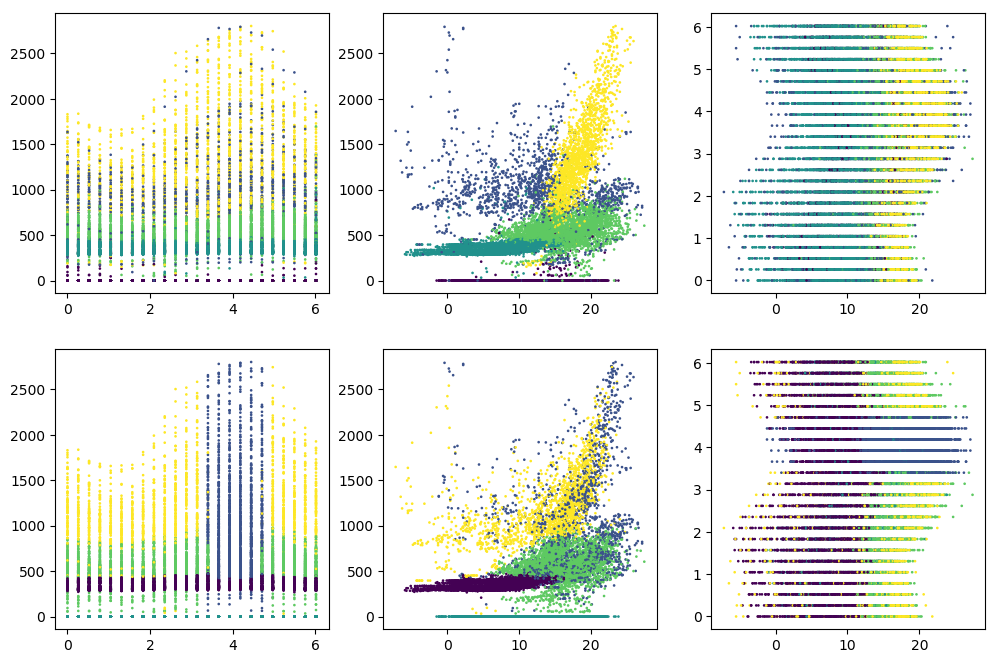

In [9]:
df = weather
#df = df[gmm.predict(prune(df)) >1]
#df = df[df['SumCh3Ch4'] == 0]

p = prune(df,['SumCh3Ch4','temp',
              'day_y','day_x'
             ])
clusters = df['cluster']
newClusters = model.predict(p)

fig = plt.figure(figsize=(12,8))
fig.add_subplot(231).scatter(df['dayFrac'], df['SumCh3Ch4'], s=.8,c=clusters)
fig.add_subplot(232).scatter(df['temp'], df['SumCh3Ch4'], s=.8,c=clusters)
fig.add_subplot(233).scatter(df['temp'], df['dayFrac'], s=.8,c=clusters)


fig.add_subplot(234).scatter(df['dayFrac'], df['SumCh3Ch4'], s=.8,c=newClusters)
fig.add_subplot(235).scatter(df['temp'], df['SumCh3Ch4'], s=.8,c=newClusters)
fig.add_subplot(236).scatter(df['temp'], df['dayFrac'], s=.8,c=newClusters)

plt.show()

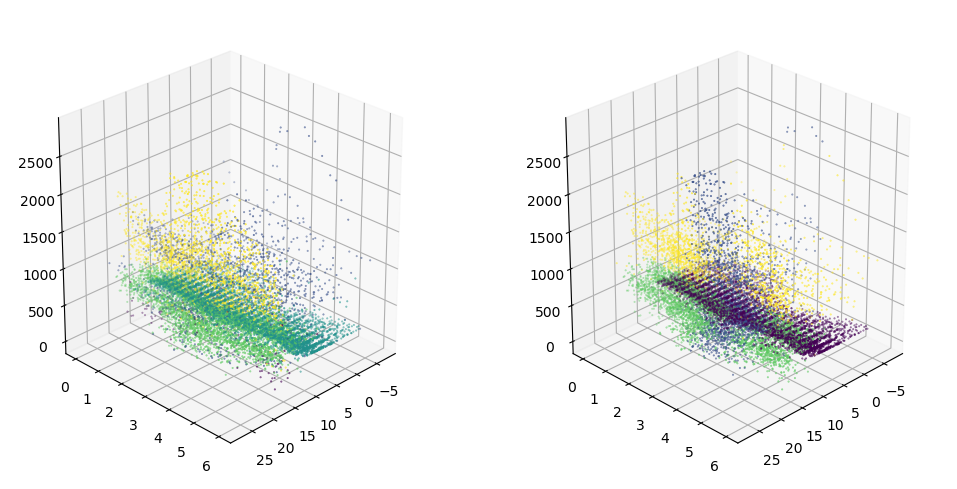

In [10]:
from mpl_toolkits.mplot3d import Axes3D

df = weather
df = df[df['SumCh3Ch4'] != 0]

p = prune(df,['SumCh3Ch4','temp','day_y','day_x'])
clusters = df['cluster']
newClusters = model.predict(p)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax.scatter(df['temp'],df['dayFrac'], df['SumCh3Ch4'],c=clusters, s=.2)
ax2.scatter(df['temp'],df['dayFrac'], df['SumCh3Ch4'],c=newClusters,s=.2)

angle = 45
elevation = 25

ax.view_init(elev=elevation, azim = angle)
ax2.view_init(elev=elevation, azim = angle)

In [21]:
scores = {}

In [12]:
def bic_score_list(data,keep,min_c=1,max_c=10):
    bic_score = []
    for k in range(min_c, max_c):
        key = (tuple(keep),k)
        if key not in scores:
            gmm = mixture.GaussianMixture(n_components=k, covariance_type='full').fit(data)
            scores[key] = gmm.bic(data)
        bic_score.append(scores[key])
    return bic_score

In [13]:
def plotBics(df,keepLists,min_c=1,max_c=10,cols = 2):
    SIZE = (12,6)
    
    n = len(keepLists)
    fig,sPlots = plt.subplots(nrows=math.ceil(n/cols), ncols= cols,sharey=True,figsize=SIZE)
    if math.ceil(n/cols) >1:
        sPlots = chain(*sPlots)    
    for i,(keep,subplot) in enumerate(zip(keepLists,sPlots)):
        bic_score = bic_score_list(prune(df,keep),keep,min_c,max_c)
        subplot.plot(range(min_c, max_c), bic_score, 'bx-')

/home/uvic/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


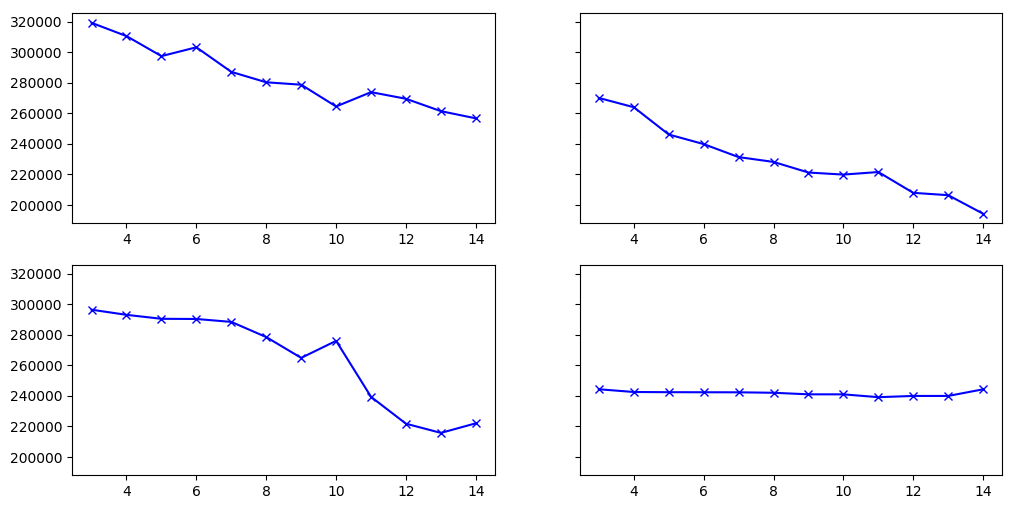

In [22]:
plotBics(df,min_c = 3, max_c =15, cols =2,
         keepLists = [
             ['SumCh3Ch4','temp','year_y','year_x','day_y','day_x'],
             ['SumCh3Ch4','temp','year_y','year_x'],
             ['SumCh3Ch4','temp','day_y','day_x'],
             ['SumCh3Ch4','temp'],
            ])


In [23]:
data = prune(df,['SumCh3Ch4','temp','day_y','day_x'])

df['newCluster'] = mixture.GaussianMixture(n_components=7, covariance_type='full').fit(data).predict(data)

/home/uvic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
groups = df.groupby(['cluster','newCluster']).size()

In [17]:
groups

cluster  newCluster
0.0      0                1
         1                3
         2                3
         3                8
         4                3
         5                4
         6               65
1.0      0                4
         1               71
         2              495
         3              320
         4               15
         5              281
         6              155
2.0      0             2099
         2               40
         3               19
         4             3006
         5              475
         6               95
3.0      0              571
         1               48
         2               49
         3              268
         4                6
         5              655
         6             2075
4.0      0                4
         1             1095
         2               19
         3              190
         5              283
         6              109
dtype: int64

In [18]:
groups.unstack().fillna(0.0)#.loc[[1,2,3,4],[0,1,2,4]]
#cluster 0 (chiller off) maps to newCluster 3
#cluster 1 (misc) is spread between 1,2,4
#

newCluster       0       1      2      3       4      5       6
cluster                                                        
0.0            1.0     3.0    3.0    8.0     3.0    4.0    65.0
1.0            4.0    71.0  495.0  320.0    15.0  281.0   155.0
2.0         2099.0     0.0   40.0   19.0  3006.0  475.0    95.0
3.0          571.0    48.0   49.0  268.0     6.0  655.0  2075.0
4.0            4.0  1095.0   19.0  190.0     0.0  283.0   109.0

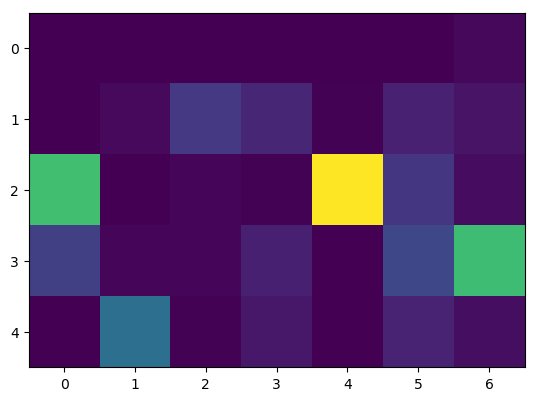

In [19]:
plt.imshow(groups.unstack().fillna(0.0).values)